In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
import numpy as np
import json
import cv2

import torch
import torch.nn.functional as F
from torchvision.utils import save_image
import networkx as nx
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import webcolors

from minimal.dataset import FloorplanGraphDataset, reader, build_graph, one_hot_embedding
from minimal.utils import draw_graph, ID_COLOR
from minimal.gen import generate_plan

%matplotlib inline

In [5]:
rms_type, rms_bbs, fp_eds, eds_to_rms = reader("data/expr.json")

In [39]:
triples, rms_masks = build_graph(rms_type, fp_eds, eds_to_rms)

In [36]:
def draw_room_from_bbs(bbs):
    plt.gca().add_patch(patches.Rectangle(
        (bbs[0], bbs[1]),
        bbs[2] - bbs[0], bbs[3] - bbs[1],
        linewidth=1, edgecolor='c', facecolor='c'
    ))
    plt.gca().invert_yaxis()

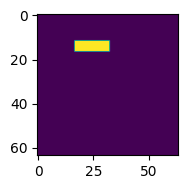

In [50]:
plt.figure(figsize=(4,4))

# plt.subplot(1,1,1)
# draw_room_from_bbs(rms_bbs[0])

plt.subplot(1,2,1)
plt.imshow(rms_masks[0])

In [7]:
nds = one_hot_embedding(np.array([5,2]))[:, 1:]

In [9]:
nds

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [20]:
 == nds

tensor(True)